In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import glob
import os
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
from torchvision import transforms, utils
from skimage import io
import random
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
import time

In [2]:
plt.ion()

In [15]:
cwd = os.getcwd()
datadir = '/'.join(cwd.split('/')[0:-1]) + '/FDR/groundtruth/'
allFiles = glob.glob(datadir + "*.xml")
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    parsedXML = ET.parse( file_ )
    a=file_.split('/')
    a=a[len(a)-1]
    a=a.split('.xml')
    data = {}
    for k,el in enumerate(parsedXML.iterfind('./*')):
        data[k]=[a[0]+"_"+list(el.items()[0])[1]]
        for i in el.iterfind('*'):
            data[k].append(int(list(i.items()[0])[1]))
            eye=[]
            for j in i.iterfind('*'):
                if (list(j.items()[0])[1]!=np.nan and list(j.items()[1])[1]!=np.nan):
                    eye.append([int(list(j.items()[0])[1]),int(list(j.items()[1])[1])])
            data[k].append(eye)
    
    df = pd.DataFrame.from_dict(data, orient='index', columns = ['img_number', 'ID', 'eye'])
    list_.append(df)
frame = pd.concat(list_,sort=False)
frame=frame.reset_index(drop=True)
frame=frame.drop([38074,38405],axis=0)
frame=frame.reset_index(drop=True)

In [16]:
a=np.where(frame['ID'].isnull(),0,1)
frame['human']=a
frame=frame[frame['human']==1]
#frame=frame.drop(['eye'],axis=1)
frame=frame.drop(['ID','human'],axis=1)

frame=frame.reset_index(drop=True)
frame.count()

img_number    72289
eye           72289
dtype: int64

In [17]:
def show_landmarks(image, a):
    """Show image with landmarks"""
    
    plt.imshow(image)
    lx=a[0][0]
    ly=a[0][1]
    rx=a[1][0]
    ry=a[1][1]
    plt.scatter(lx, ly, s=10, marker='.', c='r')
    plt.scatter(rx, ry, s=10, marker='.', c='r')
    
    dis=rx-lx
    x1=lx-0.65*dis
    x2=rx+0.65*dis
    width=x2-x1
    height=1.5*(x2-x1)
    y1=ly-0.6*height
    y2=ly+0.6*height
    x_1=[x1,x1]
    y_1=[y1,y2]
    x_2=[x2,x2]
    y_2=[y1,y2]
    x_3=[x1,x2]
    y_3=[y1,y1]
    x_4=[x1,x2]
    y_4=[y2,y2]
    plt.plot(x_1,y_1,x_2,y_2,x_3,y_3,x_4,y_4,color='green')
        #xvals=np.array(frange(lx-0.27*dis,rx+0.27*dis,0.5))
        #yvals=ly+m*(xvals-lx)
        #plt.plot(xvals,yvals)
    plt.pause(0.001)

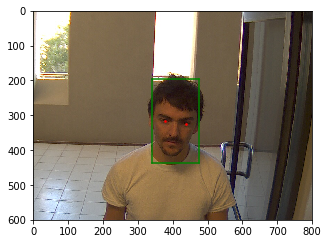

In [18]:
plt.figure(figsize=(5,4))
k=200
show_landmarks(io.imread(os.path.join('images','{}.jpg'.format(frame.loc[k]['img_number']))),frame.loc[k]['eye'])

In [19]:
def gaussian(ins, is_training, mean, stddev):
    if is_training:
        noise = Variable(ins.data.new(ins.size()).normal_(mean, stddev))
        return ins + noise
    return ins

In [20]:
class FaceDataset(Dataset):
    def __init__(self, dataframe, img_dir, noise, flip,transform=None):
        self.df=dataframe
        self.img_dir=img_dir
        self.transform=transform
        self.noise=noise
        self.flip=flip
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        image=io.imread(os.path.join(self.img_dir,'{}.jpg'.format(frame.loc[idx]['img_number'])))
        eye=self.df.loc[idx]['eye']
        sample={'image':image,'eye':eye }
        if self.transform:
            sample['image']=self.transform(sample['image'])
            sample['eye']=np.array(sample['eye'])
            sample['eye']=sample['eye']*180/600
            if(self.flip==1):
                sample['image']=transforms.functional.hflip(sample['image'])
                eyes=[240-sample['eye'][0][0],sample['eye'][0][1],240-sample['eye'][1][0],sample['eye'][1][1]]
            else:
                eyes=[sample['eye'][0][0],sample['eye'][0][1],sample['eye'][1][0],sample['eye'][1][1]]
            sample['image']=transforms.functional.to_tensor(sample['image'])
            if (self.noise==1):
                sample['image']=gaussian(sample['image'],1,0,0.08)
            
            sample['eye']=torch.tensor(eyes)
        return sample

In [21]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [22]:
transformed_dataset = FaceDataset(frame,img_dir='images/',noise=0,flip=0,transform=transforms.Compose([transforms.ToPILImage(),transforms.Resize((180,240))]))
transformed_dataset2 = FaceDataset(frame,img_dir='images/',noise=1,flip=0,transform=transforms.Compose([transforms.ToPILImage(),transforms.Resize((180,240))]))
transformed_dataset3 = FaceDataset(frame,img_dir='images/',noise=1,flip=1,transform=transforms.Compose([transforms.ToPILImage(),transforms.Resize((180,240))]))
transformed_dataset4 = FaceDataset(frame,img_dir='images/',noise=0,flip=1,transform=transforms.Compose([transforms.ToPILImage(),transforms.Resize((180,240))]))

In [23]:
for i in range(180,185):
    sample=transformed_dataset[i]
    print (i,sample['image'].size(),sample['eye'].size())

180 torch.Size([3, 180, 240]) torch.Size([4])
181 torch.Size([3, 180, 240]) torch.Size([4])
182 torch.Size([3, 180, 240]) torch.Size([4])
183 torch.Size([3, 180, 240]) torch.Size([4])
184 torch.Size([3, 180, 240]) torch.Size([4])


In [24]:
def imshow(img,a):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    lx=a[0]
    ly=a[1]
    rx=a[2]
    ry=a[3]
    
    dis=rx-lx
    x1=lx-0.9*dis
    x2=rx+0.9*dis
    width=x2-x1
    height=1.5*(x2-x1)
    y1=ly-0.5*height
    y2=ly+0.5*height
    x_1=[x1,x1]
    y_1=[y1,y2]
    x_2=[x2,x2]
    y_2=[y1,y2]
    x_3=[x1,x2]
    y_3=[y1,y1]
    x_4=[x1,x2]
    y_4=[y2,y2]
    plt.plot(x_1,y_1,x_2,y_2,x_3,y_3,x_4,y_4,color='green')
    plt.pause(0.001)

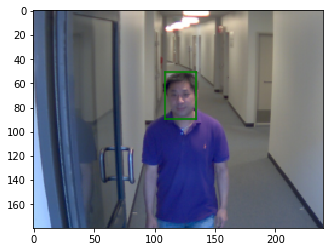

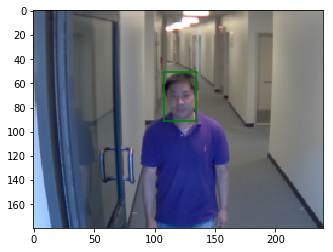

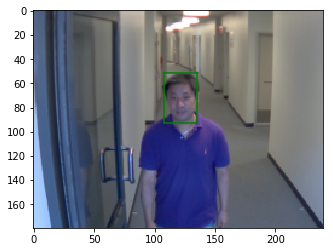

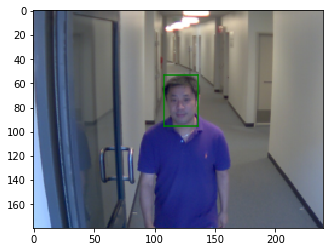

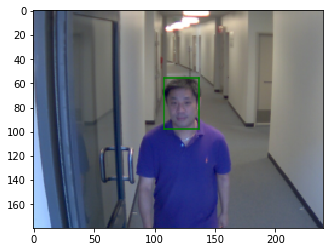

In [25]:
for i in range(3981,3986):
    sample=transformed_dataset[i]
    imshow(sample['image'],sample['eye'])
    plt.show()

In [26]:
random.seed(0)

In [27]:
num_train=len(transformed_dataset)
indices=list(range(num_train))
test_idx = indices[-12000:]
train_idx = list(set(indices) - set(test_idx))
test_data = Subset(transformed_dataset,test_idx)
validation_idx = train_idx[-8289:]
train_idx = list(set(train_idx) - set(validation_idx))
train_data = Subset(transformed_dataset,train_idx)
train_data2 = Subset(transformed_dataset2,train_idx)
train_data3 = Subset(transformed_dataset3,train_idx)
train_data4 = Subset(transformed_dataset4,train_idx)
validation_data = Subset(transformed_dataset,validation_idx)


In [28]:
train=ConcatDataset([train_data,train_data4])

In [29]:
train_loader = torch.utils.data.DataLoader(train,shuffle=True,batch_size=100)
validation_loader = torch.utils.data.DataLoader(validation_data,shuffle=True,batch_size=1)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True,batch_size=1)

In [30]:
def error(p,l):
    lx_p=p[0]
    ly_p=p[1]
    rx_p=p[2]
    ry_p=p[3]
    lx_l=l[0]
    ly_l=l[1]
    rx_l=l[2]
    ry_l=l[3]
    
    dis_p=rx_p-lx_p
    x1_p=lx_p-0.9*dis_p
    x2_p=rx_p+0.9*dis_p
    width_p=x2_p-x1_p
    height_p=1.5*(x2_p-x1_p)
    y1_p=ly_p-0.5*height_p
    y2_p=ly_p+0.5*height_p
    boxA=[x1_p,y1_p,x2_p,y2_p]
    
    dis_l=rx_l-lx_l
    x1_l=lx_l-0.9*dis_l
    x2_l=rx_l+0.9*dis_l
    width_l=x2_l-x1_l
    height_l=1.5*(x2_l-x1_l)
    y1_l=ly_l-0.5*height_l
    y2_l=ly_l+0.5*height_l
    boxB=[x1_l,y1_l,x2_l,y2_l]
    
    return (bb_intersection_over_union(boxA, boxB))

In [31]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
 
	# compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
 
	# compute the area of both the prediction and ground-truth
	# rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
 
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
 
	# return the intersection over union value
    return iou

In [32]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1a=nn.Conv2d(3,32,1)
        self.pool1a=nn.MaxPool2d(2,2)
        self.pool2a=nn.MaxPool2d(3,3)
        self.conv2a=nn.Conv2d(32,64,1)
        self.conv3a=nn.Conv2d(64,32,1)
        self.conv4a=nn.Conv2d(32,16,1)
        self.l1a=nn.Linear(15*20*16,200)
        self.l2a=nn.Linear(200,4)
        
        self.conv1b=nn.Conv2d(3,32,5)
        self.pool1b=nn.MaxPool2d(2,2)
        self.conv2b=nn.Conv2d(32,64,5)
        self.pool2b=nn.MaxPool2d(3,3)
        self.conv3b=nn.Conv2d(64,32,5)
        self.pool3b=nn.MaxPool2d(2,2)
        self.conv4b=nn.Conv2d(32,16,5)
        self.l1b=nn.Linear(8*13*16,200)
        self.l2b=nn.Linear(200,4)
        
        self.ReLU=nn.ReLU()
        
    def forward(self,x):
        out=self.conv1a(x)
        out=self.pool1a(out)
        out=self.ReLU(out)
        out=self.conv2a(out)
        out=self.pool2a(out)
        out=self.ReLU(out)
        out=self.conv3a(out)
        out=self.pool1a(out)
        out=self.ReLU(out)
        out=self.conv4a(out)
        out=self.ReLU(out)
        out=out.view(-1,15*20*16)
        out=self.l1a(out)
        out=self.ReLU(out)
        out=self.l2a(out)
        
        out1=self.conv1b(x)
        out1=self.pool1b(out1)
        out1=self.ReLU(out1)
        out1=self.conv2b(out1)
        out1=self.pool2b(out1)
        out1=self.ReLU(out1)
        out1=self.conv3b(out1)
        out1=self.pool3b(out1)
        out1=self.ReLU(out1)
        out1=self.conv4b(out1)
        out1=self.ReLU(out1)
        out1=out1.view(-1,8*13*16)
        out1=self.l1b(out1)
        out1=self.ReLU(out1)
        out1=self.l2b(out1)
        
        y=(out+out1)/2
        
        return y

In [33]:
model = Model()

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model=model.to(device)

cuda:0


In [35]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

In [36]:
checkpoint = torch.load('BB.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epochs = checkpoint['epoch']
rl = checkpoint['loss']
acc_cv=checkpoint['validation_accuracy']

model.eval()

Model(
  (conv1a): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (pool1a): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2a): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2a): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv3a): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv4a): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
  (l1a): Linear(in_features=4800, out_features=200, bias=True)
  (l2a): Linear(in_features=200, out_features=4, bias=True)
  (conv1b): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1b): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2b): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2b): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv3b): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool3b): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (

In [43]:
num_epochs=1
len(train_loader), epochs

(1040, 32)

Epoch: [1/1], Step: [1/10], Loss: 3.954, Average training time per batch: 1.778 seconds
Epoch: [1/1], Step: [2/10], Loss: 3.532, Average training time per batch: 1.808 seconds
Epoch: [1/1], Step: [3/10], Loss: 2.577, Average training time per batch: 1.786 seconds
Epoch: [1/1], Step: [4/10], Loss: 2.241, Average training time per batch: 1.814 seconds
Epoch: [1/1], Step: [5/10], Loss: 1.903, Average training time per batch: 1.796 seconds
Accuracy (IoU) on the validation dataset: 63.714%, Time for validation: 153.357 seconds
Epoch: [1/1], Step: [6/10], Loss: 1.78, Average training time per batch: 1.748 seconds
Epoch: [1/1], Step: [7/10], Loss: 1.711, Average training time per batch: 1.812 seconds
Epoch: [1/1], Step: [8/10], Loss: 1.688, Average training time per batch: 1.83 seconds
Epoch: [1/1], Step: [9/10], Loss: 2.478, Average training time per batch: 1.783 seconds
Epoch: [1/1], Step: [10/10], Loss: 1.589, Average training time per batch: 1.754 seconds
Accuracy (IoU) on the validation 

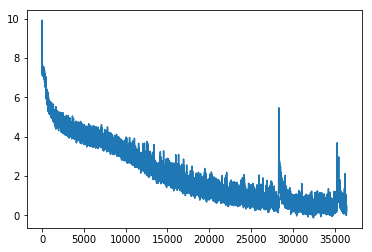

In [46]:
#acc_cv=[]
#rl=[]
for epoch in range(epochs,epochs+num_epochs):
    runningloss=0
    since = time.time()
    for i,(sample) in enumerate(train_loader):
        
        images = sample['image']
        images=images.to(device)
        labels=sample['eye']
        labels=labels.to(device)
    
        optimizer.zero_grad()
        output=model(images)
    
        loss=criterion(output,labels)
        loss.backward()
        optimizer.step()
        runningloss+=loss.item()
        rl.append(loss.item())
        
        
        if (i+1) % 104 == 0:  
            print('Epoch: [{}/{}], Step: [{}/{}], Loss: {}, Average training time per batch: {} seconds'.format(epoch+1-epochs, num_epochs, int((i+1)/104),10 , round(runningloss/104,3), round((time.time()-since)/104,3)))
            runningloss=0
            since = time.time()
        
        
            
        if (i+1)%520==0:
            iou=[]
            for j,samp in enumerate(validation_loader):
                im = Variable(samp['image'])
                im=im.to(device)
                ot = model(im)

                lb=Variable(samp['eye'])
                lb=lb.to(device)
    
                a=ot.cpu()[0].detach().numpy()
                b=lb.cpu()[0].detach().numpy()
                iou.append(error(a,b))
            
            acc_cv.append(np.mean(np.array(iou)))
            print ('Accuracy (IoU) on the validation dataset: {}%, Time for validation: {} seconds'.format(round(acc_cv[len(acc_cv)-1]*100,3), round(time.time()-since,3)))
            since=time.time()
                   
            
                
    print ('Accuracy (IoU) on the validation dataset: {}%, --Saving the model--'.format(round(acc_cv[len(acc_cv)-1]*100,3)))
    torch.save({
            'epoch': int(len(acc_cv)/2),
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': rl,
            'validation_accuracy':acc_cv,
            },'BB_temp.pth')


plt.plot(range(len(rl)),np.log(rl))

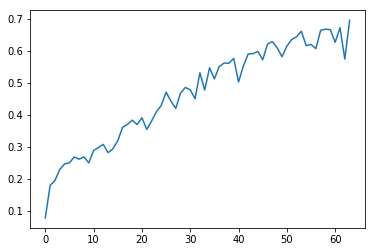

In [26]:
plt.plot(range(len(acc_cv)),(acc_cv))

In [58]:
torch.save({
            'epoch': int(len(acc_cv)/2),
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': rl,
            'validation_accuracy':acc_cv,
            },'BB.pth')

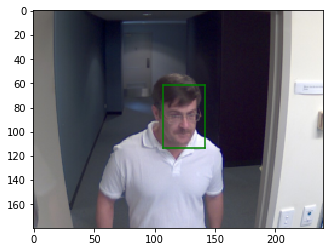

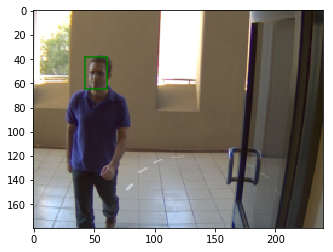

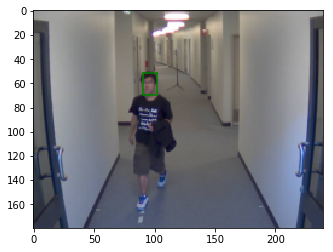

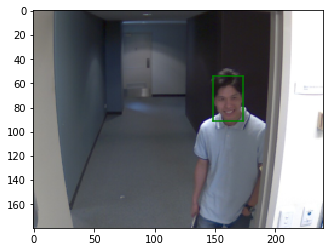

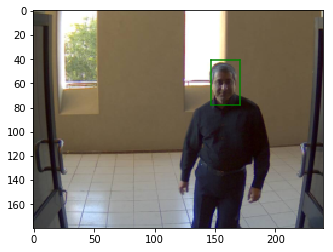

In [38]:
for j,samp in enumerate(validation_loader):
    im = Variable(samp['image'])
    lb=samp['eye']
    im=im.to(device)
    ot = model(im)
    imshow(im.cpu()[0],ot.cpu()[0].detach().numpy())
    #imshow(im.cpu()[0],lb.cpu()[0].detach().numpy())
    if(j>=4):
        break
#plt.show()


In [27]:
iou=[]
for j,samp in enumerate(test_loader):
    im = Variable(samp['image'])
    im=im.to(device)
    ot = model(im)
    
    
    lb=Variable(samp['eye'])
    lb=lb.to(device)
    
    a=ot.cpu()[0].detach().numpy()
    b=lb.cpu()[0].detach().numpy()
    iou.append(error(a,b))
    
    
    #if (l.item()>2):
     #   loss_val+=1
iou=np.array(iou)
print ('Accuracy on test data:{}'.format(np.mean(iou)))


Accuracy on test data:0.699198942317287
